# 1. Exploration

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
import seaborn as sns
sns.set_theme(style="darkgrid")

In [2]:
# source = "/content/gdrive/My Drive/Colab Notebooks/fer2013/fer2013.csv" 
source = 'fer2013/fer2013.csv'
data = pd.read_csv(source)
# data.head()
data['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

<AxesSubplot:>

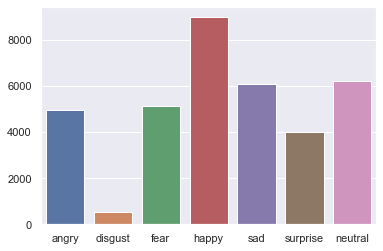

In [3]:
# categorical labels: 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
clases = {
    0:'angry',
    1:'disgust',
    2:'fear',
    3:'happy',
    4:'sad',
    5:'surprise',
    6:'neutral',
}

# data['emotion'].value_counts()
dict_clases ={
    clases[0]: data['emotion'].value_counts()[0],
    clases[1]: data['emotion'].value_counts()[1],
    clases[2]: data['emotion'].value_counts()[2],
    clases[3]: data['emotion'].value_counts()[3],
    clases[4]: data['emotion'].value_counts()[4],
    clases[5]: data['emotion'].value_counts()[5],
    clases[6]: data['emotion'].value_counts()[6],
}

keys = list(dict_clases.keys())
vals = [dict_clases[k] for k in keys] # get values in the same order as keys
sns.barplot(x=keys, y=vals)

In [4]:
rows = data.shape[0]
columns = data.shape[1]
print(f'Hay {rows} filas y {columns} columnas')

Hay 35887 filas y 3 columnas


In [5]:
# from google.colab.patches import cv2_imshow

sample_imgs = []
sample_class = []

for i in range(1,10):
    id = np.random.randint(1,rows)
    
    line = data['pixels'][id] # image id
    clase = data['emotion'][id]  # image class
    
    image_data = np.asarray([int(x) for x in line.split()])  # numpy array
    img = image_data.reshape((48,48)).astype('uint8')*255  # 2-d numpy array
    img = cv2.bitwise_not(img)  # w&b bitwise inverted or do not multiply by 255
    
    # print(f'ID:{id} \n{clases[clase]}')
    # cv2_imshow(img)  # patch for colabs instead of cv2.imshow
    sample_imgs.append(cv2.flip(img, 0))
    sample_class.append(clases[clase])

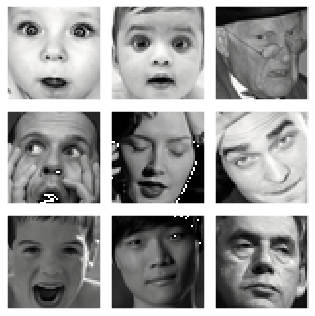

In [6]:
# !pip install seaborn-image
import seaborn_image as isns
g = isns.ImageGrid(sample_imgs, 
                   col_wrap=3, 
                   height=1.5, 
                   cmap="gray", 
                   cbar_label=sample_class, 
                   cbar=False, 
                   orientation='h')

# 2. Training

In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib

def get_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_gpus())
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

['/device:GPU:0']
2.5.0
Num GPUs Available:  1


In [2]:
# training

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import random
import seaborn as sns
import cv2
from tqdm import tqdm

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K 
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, Activation, Dropout, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras.models import model_from_json
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

sns.set_theme(style="dark")

In [3]:
# Training  28709
# Test      7178 (public+private)
source = 'fer2013/fer2013.csv'
data = pd.read_csv(source)
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
data['Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [5]:
# splitting the dataset

KerasSplit = False
train_data = []
train_label =[]
test_data = []
test_label = []
private_data = []
private_label = []

total_train = data.shape[0]
pbar = tqdm(total=total_train, desc='Loading training images')
for index, row in data.iterrows():
    
    image_bw = np.asarray([int(x) for x in row['pixels'].split()])
    image_bw = image_bw.reshape(48, 48).astype('uint8')/255  # /255 normalized
    # image_bw = cv2.flip(image_bw, 0)
    
    if KerasSplit:
        train_data.append(image_bw)
        train_label.append(row['emotion'])
    else:
        if row['Usage'] == 'Training':
            train_data.append(image_bw)
            train_label.append(row['emotion'])
        elif row['Usage'] == 'PublicTest':
            test_data.append(image_bw)
            test_label.append(row['emotion'])
        else:
            private_data.append(image_bw)
            private_label.append(row['emotion'])
    pbar.update(1)
pbar.close()

train_data = np.array(np.expand_dims(train_data, -1))   
train_label = np.array(to_categorical(train_label, num_classes = 7))
test_data = np.array(np.expand_dims(test_data, -1))
test_label = np.array(to_categorical(test_label, num_classes = 7))
private_data = np.array(np.expand_dims(private_data, -1))   
private_label = np.array(to_categorical(private_label, num_classes = 7))
print(f'[info training] \ntraining data: {len(train_data)} \ntraining labels: {len(train_label)}')
print(f'[public test] \ntraining data: {len(test_data)} \ntraining labels: {len(test_label)}')
print(f'[public test] \ntraining data: {len(private_data)} \ntraining labels: {len(private_label)}')

Loading training images: 100%|█████████████████████████████████████████████████| 35887/35887 [00:19<00:00, 1842.14it/s]


[info training] 
training data: 28709 
training labels: 28709
[public test] 
training data: 3589 
training labels: 3589
[public test] 
training data: 3589 
training labels: 3589


[0. 0. 0. 0. 1. 0. 0.]


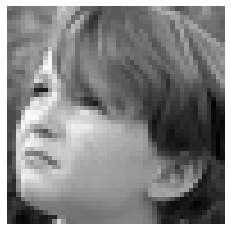

In [6]:
id_random = random.randint(0, len(train_data))
print(train_label[id_random])
plt.imshow(train_data[id_random], cmap='gray', interpolation='nearest')
plt.axis('off')
plt.show()

In [7]:
print(f'imágenes para entrenamiento: {len(train_data)} \nimágenes para validación: {len(test_data)}')

imágenes para entrenamiento: 28709 
imágenes para validación: 3589


**Hyperparameters**

In [9]:
epochs = 60
batch_size = 64
learning_rate = 0.001  # (SGD=1E-2, Adam=1E-3)
lr_factor = 0.9  # 0.9 - learning rate factor in plateau
lr_patience = 6  # 6 - learning rate factor in plateau
validation = 0.2 # validation split
SGD = False
jup = 'jup03b'

In [10]:
model = Sequential()
    
model.add(Conv2D(64, (5, 5), activation='relu', input_shape=(48, 48, 1))) # kernel_regularizer=l2(0.01)
model.add(Conv2D(64, (5, 5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))
    
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
    
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
    
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
    
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

if SGD:
    optimType = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
else:
    optimType = optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimType, loss='categorical_crossentropy', metrics=['accuracy'])
    
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 44, 44, 64)        1664      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 44, 44, 64)        102464    
_________________________________________________________________
batch_normalization_10 (Batc (None, 44, 44, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 22, 22, 128)       73856     
_________________________________________________________________
batch_normalization_11 (Batc (None, 22, 22, 128)      

In [11]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=lr_factor, patience=lr_patience)
early_stopper = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, mode='auto')
checkpointer = ModelCheckpoint('models/'+jup+'/weights.hd5', monitor='val_loss', verbose=1, save_best_only=True)

history = model.fit(train_data,
          train_label,
          batch_size=batch_size,
          epochs=epochs, 
          callbacks=[lr_reducer, checkpointer, early_stopper], 
          # validation_split=validation,
          validation_data=(test_data, test_label),
          shuffle=True, 
          verbose=1
         )

Epoch 1/60
449/449 [==============================] - 31s 46ms/step - loss: 2.0458 - accuracy: 0.2050 - val_loss: 1.8394 - val_accuracy: 0.2494

Epoch 00001: val_loss improved from inf to 1.83939, saving model to models/jup03b\weights.hd5
INFO:tensorflow:Assets written to: models/jup03b\weights.hd5\assets
Epoch 2/60
449/449 [==============================] - 20s 44ms/step - loss: 1.8413 - accuracy: 0.2396 - val_loss: 1.8230 - val_accuracy: 0.2494

Epoch 00002: val_loss improved from 1.83939 to 1.82297, saving model to models/jup03b\weights.hd5
INFO:tensorflow:Assets written to: models/jup03b\weights.hd5\assets
Epoch 3/60
449/449 [==============================] - 20s 44ms/step - loss: 1.8230 - accuracy: 0.2486 - val_loss: 1.8042 - val_accuracy: 0.2494

Epoch 00003: val_loss improved from 1.82297 to 1.80424, saving model to models/jup03b\weights.hd5
INFO:tensorflow:Assets written to: models/jup03b\weights.hd5\assets
Epoch 4/60
449/449 [==============================] - 20s 44ms/step - l


Epoch 00032: val_loss improved from 1.22984 to 1.21316, saving model to models/jup03b\weights.hd5
INFO:tensorflow:Assets written to: models/jup03b\weights.hd5\assets
Epoch 33/60
449/449 [==============================] - 20s 44ms/step - loss: 1.2051 - accuracy: 0.5338 - val_loss: 1.2036 - val_accuracy: 0.5378

Epoch 00033: val_loss improved from 1.21316 to 1.20363, saving model to models/jup03b\weights.hd5
INFO:tensorflow:Assets written to: models/jup03b\weights.hd5\assets
Epoch 34/60
449/449 [==============================] - 20s 44ms/step - loss: 1.1713 - accuracy: 0.5487 - val_loss: 1.2543 - val_accuracy: 0.5369

Epoch 00034: val_loss did not improve from 1.20363
Epoch 35/60
449/449 [==============================] - 20s 44ms/step - loss: 1.1518 - accuracy: 0.5599 - val_loss: 1.2064 - val_accuracy: 0.5570

Epoch 00035: val_loss did not improve from 1.20363
Epoch 36/60
449/449 [==============================] - 20s 44ms/step - loss: 1.1318 - accuracy: 0.5671 - val_loss: 1.2379 - val

In [12]:
model_json = model.to_json()

with open('models/'+jup+'/model.json', "w") as json_file:
    json_file.write(model_json)

model.save_weights('models/'+jup+'/model.h5')
print("Saved model to disk")

Saved model to disk


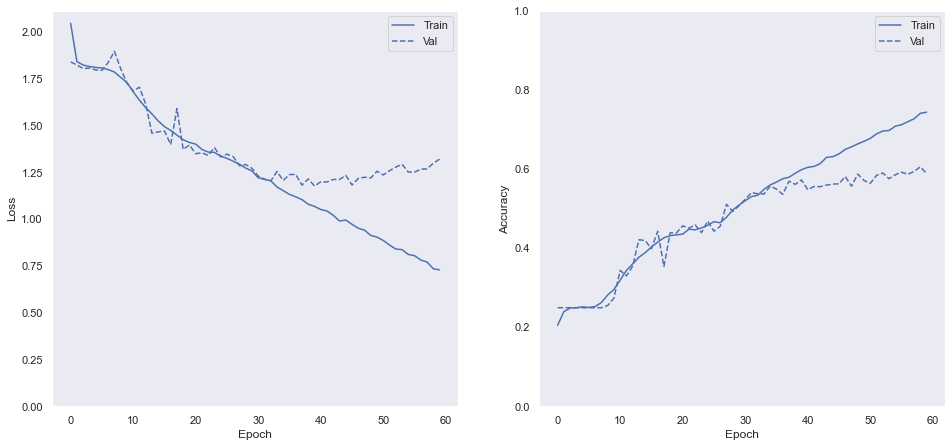

In [13]:
metrics = ['loss', 'accuracy']  # , 'precision', 'recall'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure(figsize=(16, 16))
for n, metric in enumerate(metrics):
    name = metric.replace("_", " ").capitalize()
    plt.subplot(2, 2, n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
        plt.ylim([0.8,1])
    else:
        plt.ylim([0,1])

    plt.legend()
plt.savefig('models/'+jup+'/'+jup+'_metrics.jpg', bbox_inches='tight')
# plt.show()